In [29]:
import pandas as pd
import os

import matplotlib.pyplot as plt

from scipy import signal

import scipy.fft as fourier
from scipy.signal.windows import hann

import numpy as np

import re

import ast

In [1]:
from pydantic import BaseModel, Field
from typing import List
class Wave(BaseModel):
    time: List[float] = Field(..., description="Time points of the wave")
    signal: List[float] = Field(..., description="Signal values")
class LoosenessModel:
    def __init__(self, **params):
        # Store hyperparameters if needed
        self.params = params
    def predict(self, wave_hor: Wave, wave_ver: Wave, wave_axi: Wave) -> bool:
        """
        Predicts the presence of structural looseness based on horizontal,
        vertical, and axial wave data.
        Args:
        wave_hor (Wave): Horizontal wave data
        wave_ver (Wave): Vertical wave data
        wave_axi (Wave): Axial wave data
        Returns:
        bool: True if looseness is detected, False otherwise
        """
        raise NotImplementedError("The 'predict' method must be implemented.")
    def score(self, wave_hor: Wave, wave_ver: Wave, wave_axi: Wave) -> float:
        """
        Computes a confidence score (between 0 and 1) representing the
        likelihood of structural looseness. This is optional.
        Args:
        wave_hor (Wave): Horizontal wave data
        wave_ver (Wave): Vertical wave data
        wave_axi (Wave): Axial wave data
        Returns:
        float: score (0 = no looseness, 1 = high confidence of looseness)
        """
        raise NotImplementedError("The 'score' method must be implemented.")

In [43]:
path = './part_3/'

metadata = pd.read_csv(path + 'part_3_metadata.csv')

dictChannel = {'Ch1 Y-Axis': 'axisX', 'Ch2 Y-Axis': 'axisY','Ch3 Y-Axis': 'axisZ','X-Axis':"time"}

In [134]:
metadata["sample_id"]

0      1f118dbd-97d8-55dc-b825-32f088a38c8e
1      fb3d36b3-d6ce-5c58-997c-818e096c996b
2      db2228bb-0707-5110-b9d0-7319a3e911bc
3      d42d2caa-0c84-5fc4-b145-6a59df0785b0
4      cf95f350-897a-5229-b6ae-e3d8b196fcf9
                       ...                 
245    9b73f7c3-c89c-5e11-bf5e-611a9963e9cb
246    57d9e35b-9d5e-55e9-b925-4867e6bfecc6
247    24666e62-e18c-528e-b6bf-9d5579fe48db
248    c33d68d9-2d32-547f-9cbd-e432a4b5addf
249    386bf8d9-1cdd-58f6-982b-b0f85665a938
Name: sample_id, Length: 250, dtype: object

In [139]:
for file in metadata["sample_id"]:
    data = pd.read_csv(path + "data/" + file + ".csv")
    if data["X-Axis"].max()>0.52:
        print(data["X-Axis"].max()) 

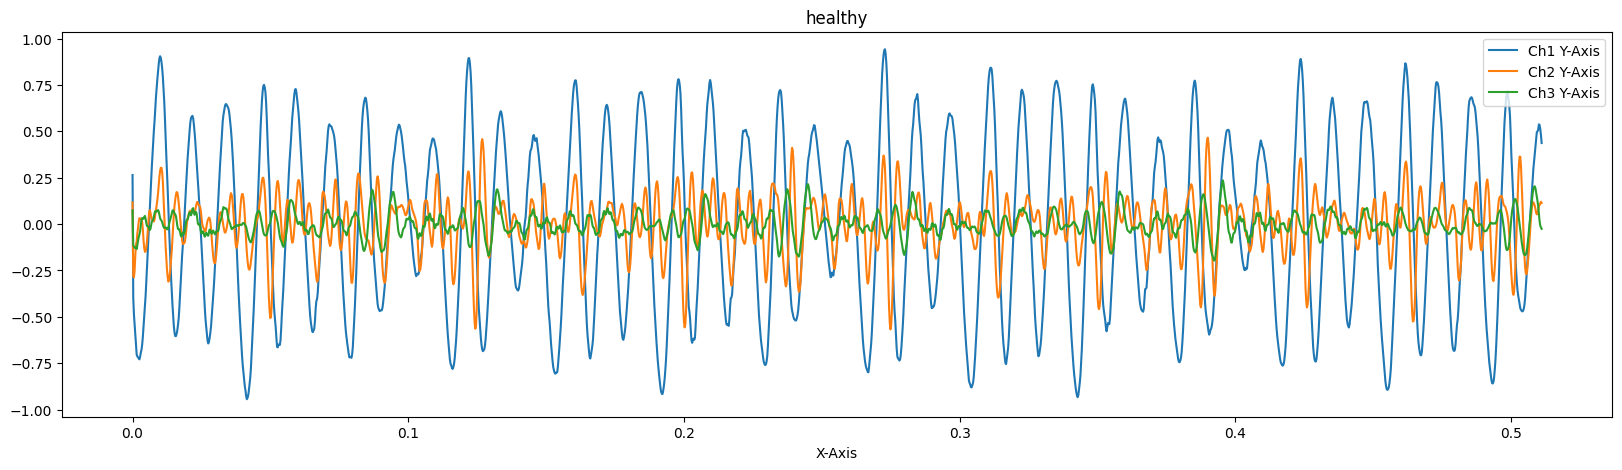

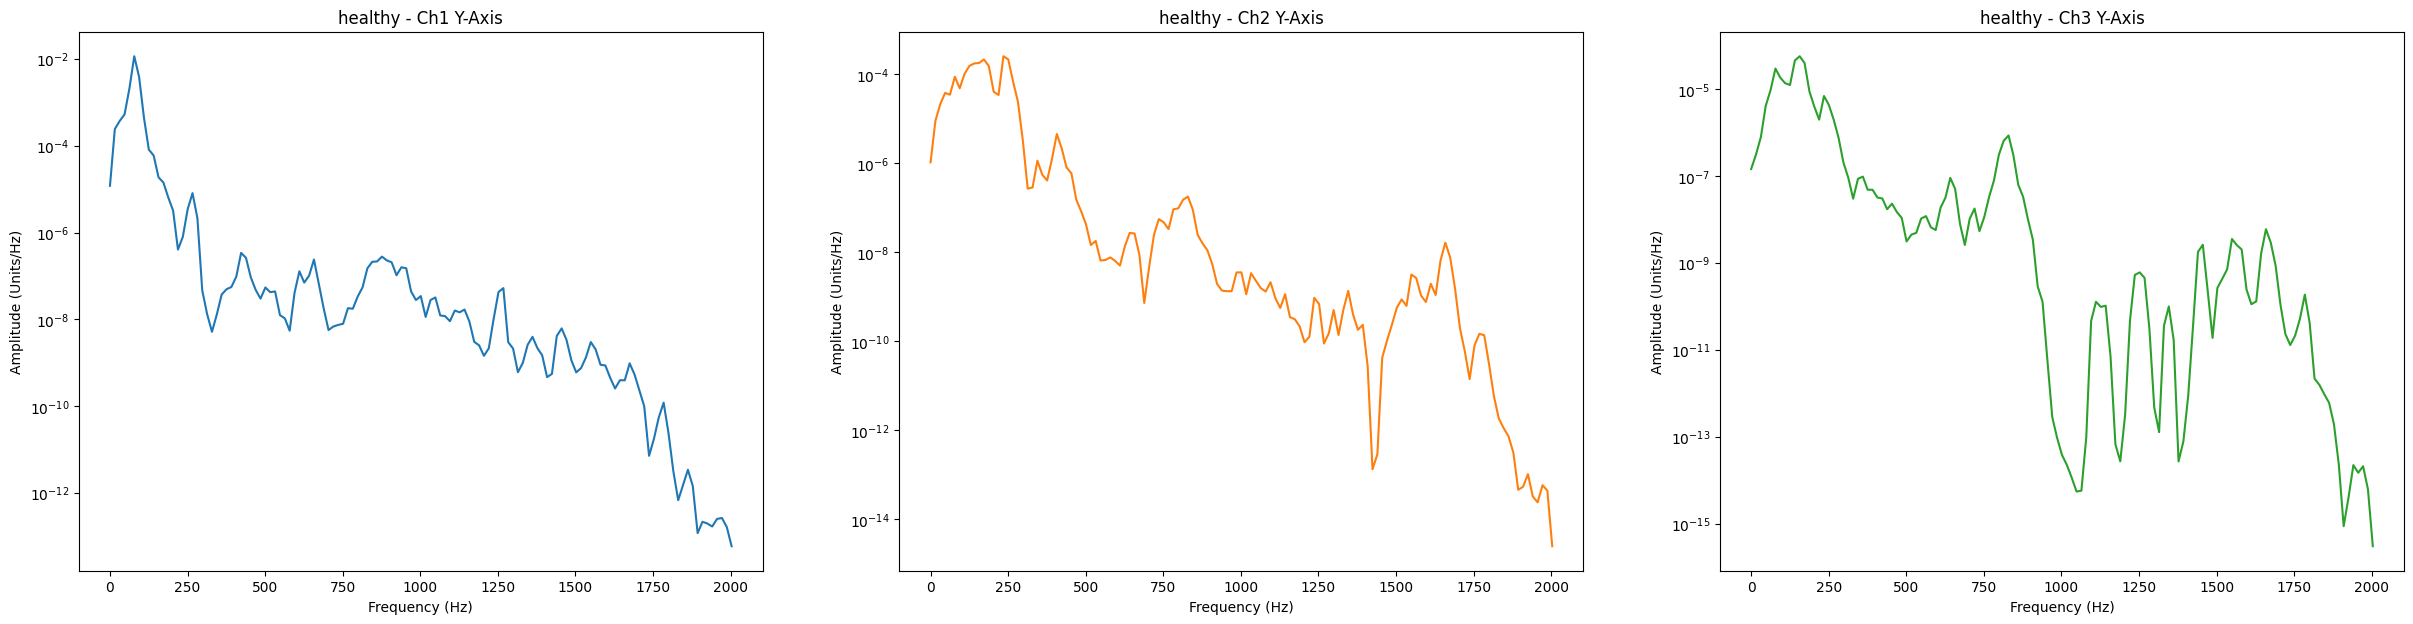

In [167]:
i = 0
data = pd.read_csv(path + "data/" + metadata["sample_id"][i] + ".csv")
data.set_index("X-Axis", inplace=True)
# data.columns = [dictChannel[name] for name in data.columns]

# dictOrientation = ast.literal_eval(metadata.iloc[i]["orientation"])

# data.columns = [dictOrientation[name] for name in data.columns if name != "time" else name]

data = data.ewm(alpha=0.1).mean() - data.mean()

data.plot(figsize=(20,5))
plt.title(metadata["condition"][i])

fig, axs = plt.subplots(1, 3, figsize=(30, 7))

fs = data.shape[0] / data.index.max() 

f, Pxx = signal.welch(data["Ch1 Y-Axis"].to_numpy(), fs=fs, window='hann', nperseg=256, noverlap=128, scaling='density',average='median')
_, Pyy = signal.welch(data["Ch2 Y-Axis"].to_numpy(), fs=fs, window='hann', nperseg=256, noverlap=128, scaling='density',average='median')
_, Pzz = signal.welch(data["Ch3 Y-Axis"].to_numpy(), fs=fs, window='hann', nperseg=256, noverlap=128, scaling='density',average='median')

P_g = [Pxx, Pyy, Pzz]

for j, ax in enumerate(axs):
    ax.semilogy(f, P_g[j], color='C'+str(j))
    ax.set_title(metadata["condition"][i] + " - " + data.columns[j])
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Amplitude (Units/Hz)')

In [142]:
#implementar um modelo de redução de banda -> ex.: de 0 a 250Hz tirar a média e usar como feature